# MNIST dataset with PyTorch

## Importing the necessary libraries

In [27]:
import torch
from torchvision import datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision

## Downloading the raw MNIST dataset

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( (0.1307, ), (0.3081, ))])

train_set = datasets.MNIST(root = "data/", train = True, transform = transform, download = True)
test_set = datasets.MNIST(root = "data/", train = False, transform = transform, download = True)

## Creating datasplits

In [29]:
train_size = 0.8
train_size = int(train_size*len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_set, [train_size, val_size])

## Creating dataloaders

In [30]:
batch_size = 4
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

## Sample visualization of a batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


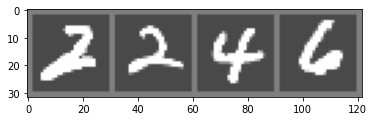

    2     2     4     6


In [31]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join(f"{labels[j]:5}" for j in range(batch_size)))

## Building the convolutional neural network (CNN)

In [32]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super(CNNNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 10, out_channels = 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(in_features = 320, out_features = 50)
        self.fc2 = nn.Linear(in_features = 50, out_features = 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool1(x)
        # Apply ReLU
        x = F.relu(x)
        x = self.conv2_drop(x)
        
        x = self.conv2(x)
        x = self.max_pool2(x)
        # Apply ReLU
        x = F.relu(x)
        # Now flatten the input        
        x = x.view(-1, 320)
        x = self.fc1(x)
        # Apply ReLU
        x = F.relu(x)
        x = self.fc2(x)
        return x

cnn_network = CNNNetwork()

## Setting the loss function and optimizer

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_network.parameters(), lr = 1e-3, momentum = 0.9)

## Train the model

In [34]:
def train_cnn_model(network, train_dataloader, val_dataloader, optimizer, criterion):
    min_val_loss = float("inf")
    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        network.train()
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            optimizer.zero_grad()

            outputs = network(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
                running_loss = 0.0


        network.eval()
        val_loss = 0
        with torch.no_grad():
            for i, data in enumerate(val_dataloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data

                # forward + backward + optimize
                outputs = network(inputs)
                loss = criterion(outputs, labels)
                # print statistics
                val_loss += loss.item()
                if i % 2000 == 1999:    # print every 2000 mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {val_loss / 2000:.3f}')
                    val_loss = 0.0
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            print(f"The new best model is at epoch {epoch}")
            torch.save(network.state_dict(), "best_model.h5")
        print(f"Epoch: {epoch} over")

train_cnn_model(network = cnn_network, train_dataloader = train_loader, val_dataloader = val_loader,
                optimizer = optimizer, criterion = criterion)

[1,  2000] loss: 0.739
[1,  4000] loss: 0.253
[1,  6000] loss: 0.197
[1,  8000] loss: 0.164
[1, 10000] loss: 0.148
[1, 12000] loss: 0.154
[1,  2000] loss: 0.084
The new best model is at epoch 0
Epoch: 0 over
[2,  2000] loss: 0.117
[2,  4000] loss: 0.116
[2,  6000] loss: 0.116
[2,  8000] loss: 0.101
[2, 10000] loss: 0.118
[2, 12000] loss: 0.111
[2,  2000] loss: 0.061
The new best model is at epoch 1
Epoch: 1 over


## Evaluating the performance on the test dataset

In [35]:
def evaluate_cnn_model(network, test_loader):
    correct = 0
    total = 0
    network.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = network(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network on the test images: {100 * correct / total} %")

evaluate_cnn_model(network = cnn_network, test_loader = test_loader)

Accuracy of the network on the test images: 98.24 %


## Visual inference on the test dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


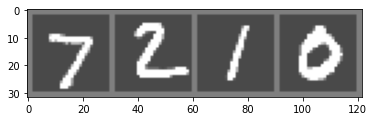

[ 7 ,   2 ,   1 ,   0 ]


In [36]:
# get some random training images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# predict digits based on model 
outputs = cnn_network(images)
_, predicted = torch.max(outputs.data, 1)
print(" ".join(f"{predicted.tolist()}"))